# ARIMA in Crude Oil, Gasoline RBOB, Heating Oil

### Các thư viện cần thiết

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.4 MB/s eta 0:00:00


In [ ]:
from pmdarima.arima import auto_arima

# Train-Test 7:3

# Crude Oil WTI - 7:3

In [ ]:
# Đọc file dữ liệu và loại bỏ những dòng bị thiếu
df= pd.read_csv('Crude Oil WTI.csv')
df = df.dropna() # Drop missing values

In [ ]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Vol.' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

# Chuyển đổi cột 'Change %' thành số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)
#df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
#df = df.iloc[::-1].reset_index(drop=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
1385,2019-03-01,55.80,57.22,57.88,55.57,684190,-2.48
1384,2019-03-04,56.59,55.83,57.00,55.81,549400,1.42
1383,2019-03-05,56.56,56.45,57.19,56.09,538400,-0.05
1382,2019-03-06,56.22,56.28,56.40,55.42,637680,-0.60
1381,2019-03-07,56.66,56.20,56.99,56.08,628820,0.78
...,...,...,...,...,...,...,...
5,2024-05-24,77.72,77.04,78.05,76.15,299080,1.11
3,2024-05-28,79.83,77.81,80.29,77.69,334070,1.50
2,2024-05-29,79.23,80.26,80.62,78.99,259589,-0.75
1,2024-05-30,77.91,79.28,79.42,77.63,373780,-1.67


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1301 entries, 1385 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1301 non-null   datetime64[ns]
 1   Price     1301 non-null   float64       
 2   Open      1301 non-null   float64       
 3   High      1301 non-null   float64       
 4   Low       1301 non-null   float64       
 5   Vol.      1301 non-null   int64         
 6   Change %  1301 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 81.3 KB


In [ ]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [ ]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [ ]:
# Tách dữ liệu train-test 7:3
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [ ]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape, '%')

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [ ]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5961.386, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6020.468, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5989.468, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5994.707, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6018.636, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5967.231, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5968.805, Time=0.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5934.731, Time=1.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5933.258, Time=0.72 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5949.453, Time=0.46 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5933.670, Time=2.62 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5976.293, Time=0.38 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=5932.390, Time=0.86 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=5933.672, Time=0.58 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept

ARIMA(order=(4, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing model
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [ ]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

# Dự đoán 60 ngày tiếp theo
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)

x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(n_periods=len(x_next_60_days))

print('Predict closing prices for the next 60 days:')
print(y_next_60_days)

#Dự đoán 90 ngày tiếp theo
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)

x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

print('Predict closing prices for the next 90 days:')
print(y_next_90_days)

Predict closing prices for the next 30 days:
[90.0568285  89.99156486 89.52699571 89.38399263 89.3632586  89.43464173
 89.50054512 89.51837729 89.51320783 89.49662955 89.48780409 89.48617184
 89.48882392 89.49167189 89.49283235 89.49271059 89.49206854 89.49162395
 89.49150699 89.49159811 89.49172136 89.49178415 89.49178639 89.49176156
 89.49174061 89.49173338 89.4917361  89.49174132 89.49174449 89.49174496]
Predict closing prices for the next 60 days:
[90.0568285  89.99156486 89.52699571 89.38399263 89.3632586  89.43464173
 89.50054512 89.51837729 89.51320783 89.49662955 89.48780409 89.48617184
 89.48882392 89.49167189 89.49283235 89.49271059 89.49206854 89.49162395
 89.49150699 89.49159811 89.49172136 89.49178415 89.49178639 89.49176156
 89.49174061 89.49173338 89.4917361  89.49174132 89.49174449 89.49174496]
Predict closing prices for the next 90 days:
[90.0568285  89.99156486 89.52699571 89.38399263 89.3632586  89.43464173
 89.50054512 89.51837729 89.51320783 89.49662955 89.48780409

- Calculate Error Values -
MAE:  11.382365778906621
MAPE:  15.084858685822066 %
RMSE:  12.531105807102467


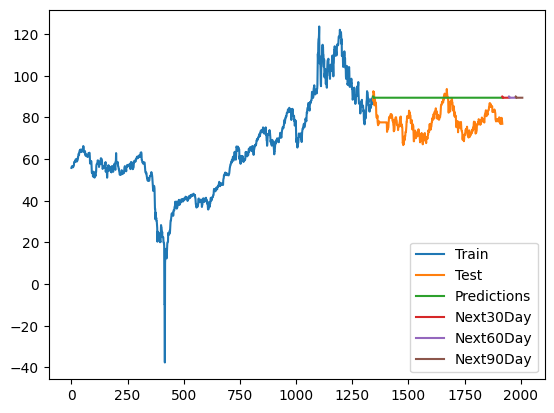

In [ ]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Gasoline RBOB - 7:3

In [ ]:
# Đọc file dữ liệu, loại bỏ những dòng bị thiếu và chuẩn hóa dữ liệu
df= pd.read_csv('Gasoline RBOB.csv')
df = df.dropna() # Drop missing values

In [ ]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Vol.' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

# Chuyển đổi cột 'Change %' thành số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
1626,2019-03-01,1.5356,1.7521,1.7720,1.7124,69010,-1.37
1624,2019-03-04,1.5530,1.7285,1.7660,1.7285,62550,-10.41
1623,2019-03-05,1.5601,1.7474,1.7735,1.7387,61430,0.46
1622,2019-03-06,1.5674,1.7604,1.7919,1.7524,91540,0.47
1621,2019-03-07,1.5743,1.7845,1.8160,1.7845,78590,0.44
...,...,...,...,...,...,...,...
4,2024-05-27,2.5140,2.5020,2.5154,2.5020,20,1.53
3,2024-05-28,2.5090,2.5151,2.5244,2.5022,330,-0.20
2,2024-05-29,2.4644,2.5208,2.5304,2.4579,1280,-1.78
1,2024-05-30,2.4046,2.4560,2.4613,2.4295,440,-2.43


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1335 entries, 1626 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1335 non-null   datetime64[ns]
 1   Price     1335 non-null   float64       
 2   Open      1335 non-null   float64       
 3   High      1335 non-null   float64       
 4   Low       1335 non-null   float64       
 5   Vol.      1335 non-null   int64         
 6   Change %  1335 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 83.4 KB


In [ ]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [ ]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [ ]:
# Tách dữ liệu train-test 7:3
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [ ]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape, '%')

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [ ]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4430.397, Time=2.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4350.451, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4379.326, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4381.973, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4352.094, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4423.330, Time=4.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4423.344, Time=2.61 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4468.100, Time=2.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4465.683, Time=2.60 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-4466.430, Time=3.00 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-4466.538, Time=5.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4467.456, Time=2.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-4468.096, Time=3.16 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-4467.184, Time=1.84 sec
 ARIMA(3,1,2)(0,0,0

ARIMA(order=(4, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing model
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [ ]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

# Dự đoán 60 ngày tiếp theo
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)

x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(n_periods=len(x_next_60_days))

print('Predict closing prices for the next 60 days:')
print(y_next_60_days)

#Dự đoán 90 ngày tiếp theo
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)

x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

print('Predict closing prices for the next 90 days:')
print(y_next_90_days)

Predict closing prices for the next 30 days:
[2.56570839 2.55114308 2.52656799 2.5239029  2.53135304 2.53819957
 2.54084577 2.53859381 2.53611235 2.53503304 2.53551225 2.53641407
 2.5368514  2.53676817 2.53647177 2.53629133 2.53629531 2.53638791
 2.53645819 2.53646621 2.53643811 2.53641216 2.53640605 2.53641413
 2.53642339 2.53642659 2.53642447 2.53642126 2.53641981 2.53642028]
Predict closing prices for the next 60 days:
[2.56570839 2.55114308 2.52656799 2.5239029  2.53135304 2.53819957
 2.54084577 2.53859381 2.53611235 2.53503304 2.53551225 2.53641407
 2.5368514  2.53676817 2.53647177 2.53629133 2.53629531 2.53638791
 2.53645819 2.53646621 2.53643811 2.53641216 2.53640605 2.53641413
 2.53642339 2.53642659 2.53642447 2.53642126 2.53641981 2.53642028]
Predict closing prices for the next 90 days:
[2.56570839 2.55114308 2.52656799 2.5239029  2.53135304 2.53819957
 2.54084577 2.53859381 2.53611235 2.53503304 2.53551225 2.53641407
 2.5368514  2.53676817 2.53647177 2.53629133 2.53629531 2.5

- Calculate Error Values -
MAE:  0.18374617582857444
MAPE:  7.754963494275505 %
RMSE:  0.22962154374554705


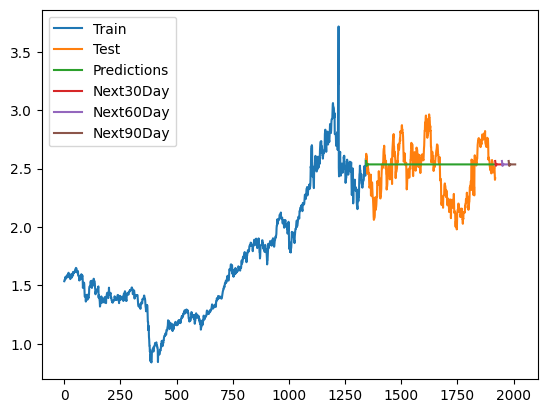

In [ ]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Heating Oil - 7:3

In [ ]:
# Đọc file dữ liệu, loại bỏ những dòng bị thiếu và chuẩn hóa dữ liệu
df= pd.read_csv('Heating Oil.csv')
df = df.dropna() # Drop missing values

In [ ]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Vol.' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

# Chuyển đổi cột 'Change %' thành số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
1384,2019-03-01,2.0010,2.0293,2.0479,1.9791,55010,-1.11
1383,2019-03-04,2.0143,1.9999,2.0377,1.9984,56050,0.66
1382,2019-03-05,2.0164,2.0110,2.0229,1.9909,45160,0.10
1381,2019-03-06,2.0162,2.0146,2.0256,1.9969,50220,-0.01
1380,2019-03-07,2.0127,2.0124,2.0356,1.9988,48590,-0.17
...,...,...,...,...,...,...,...
6,2024-05-24,2.4136,2.4175,2.4302,2.3897,21870,0.07
3,2024-05-28,2.4650,2.4148,2.4800,2.4131,28960,0.57
2,2024-05-29,2.4370,2.4801,2.4935,2.4295,22870,-1.14
1,2024-05-30,2.3694,2.4305,2.4368,2.3637,18120,-2.77


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1324 entries, 1384 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1324 non-null   datetime64[ns]
 1   Price     1324 non-null   float64       
 2   Open      1324 non-null   float64       
 3   High      1324 non-null   float64       
 4   Low       1324 non-null   float64       
 5   Vol.      1324 non-null   int64         
 6   Change %  1324 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 82.8 KB


In [ ]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [ ]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [ ]:
# Tách dữ liệu train-test 7:3
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [ ]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape, '%')

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [ ]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3513.833, Time=3.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3481.484, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3487.317, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3486.989, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3483.004, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3483.025, Time=1.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3484.364, Time=2.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3510.142, Time=3.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3510.437, Time=6.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3486.286, Time=1.68 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3482.414, Time=1.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3485.003, Time=2.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-3508.128, Time=5.19 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-3515.422, Time=2.00 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing model
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [ ]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

# Dự đoán 60 ngày tiếp theo
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)

x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(n_periods=len(x_next_60_days))

print('Predict closing prices for the next 60 days:')
print(y_next_60_days)

#Dự đoán 90 ngày tiếp theo
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)

x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

print('Predict closing prices for the next 90 days:')
print(y_next_90_days)

Predict closing prices for the next 30 days:
[3.60879876 3.62500601 3.68446488 3.68001771 3.62993909 3.62603776
 3.667056   3.67651967 3.6438734  3.63105796 3.65623958 3.67070767
 3.65197908 3.63711668 3.65042367 3.6647913  3.65591403 3.64262945
 3.64799038 3.65984166 3.65718502 3.64693487 3.64758741 3.65620318
 3.65696792 3.64992513 3.64822139 3.65381476 3.65607885 3.65177479]
Predict closing prices for the next 60 days:
[3.60879876 3.62500601 3.68446488 3.68001771 3.62993909 3.62603776
 3.667056   3.67651967 3.6438734  3.63105796 3.65623958 3.67070767
 3.65197908 3.63711668 3.65042367 3.6647913  3.65591403 3.64262945
 3.64799038 3.65984166 3.65718502 3.64693487 3.64758741 3.65620318
 3.65696792 3.64992513 3.64822139 3.65381476 3.65607885 3.65177479]
Predict closing prices for the next 90 days:
[3.60879876 3.62500601 3.68446488 3.68001771 3.62993909 3.62603776
 3.667056   3.67651967 3.6438734  3.63105796 3.65623958 3.67070767
 3.65197908 3.63711668 3.65042367 3.6647913  3.65591403 3.6

- Calculate Error Values -
MAE:  0.8414208020735542
MAPE:  31.565854959053286 %
RMSE:  0.9004391863481036


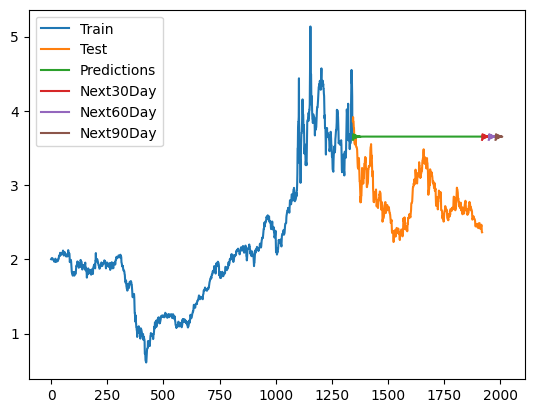

In [ ]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Train-Test 8:2

# Crude Oil WTI - 8:2

In [ ]:
# Đọc file dữ liệu và loại bỏ những dòng bị thiếu
df= pd.read_csv('Crude Oil WTI.csv')
df = df.dropna() # Drop missing values

In [ ]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Vol.' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

# Chuyển đổi cột 'Change %' thành số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
1385,2019-03-01,55.80,57.22,57.88,55.57,684190,-2.48
1384,2019-03-04,56.59,55.83,57.00,55.81,549400,1.42
1383,2019-03-05,56.56,56.45,57.19,56.09,538400,-0.05
1382,2019-03-06,56.22,56.28,56.40,55.42,637680,-0.60
1381,2019-03-07,56.66,56.20,56.99,56.08,628820,0.78
...,...,...,...,...,...,...,...
5,2024-05-24,77.72,77.04,78.05,76.15,299080,1.11
3,2024-05-28,79.83,77.81,80.29,77.69,334070,1.50
2,2024-05-29,79.23,80.26,80.62,78.99,259589,-0.75
1,2024-05-30,77.91,79.28,79.42,77.63,373780,-1.67


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1301 entries, 1385 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1301 non-null   datetime64[ns]
 1   Price     1301 non-null   float64       
 2   Open      1301 non-null   float64       
 3   High      1301 non-null   float64       
 4   Low       1301 non-null   float64       
 5   Vol.      1301 non-null   int64         
 6   Change %  1301 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 81.3 KB


In [ ]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [ ]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [ ]:
# Tách dữ liệu train-test 8:2
train_size = int(0.8 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [ ]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape, '%')

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [ ]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6684.950, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6743.427, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6714.211, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6719.243, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6741.457, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6688.464, Time=0.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6690.390, Time=0.85 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6655.635, Time=1.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6654.598, Time=0.86 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6670.428, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=6654.422, Time=1.35 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=6653.043, Time=0.83 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=6654.359, Time=1.19 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=6655.828, Time=3.33 sec
 ARIMA(4,1,0)(0,0,0)[0]          

ARIMA(order=(4, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing model
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [ ]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

# Dự đoán 60 ngày tiếp theo
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)

x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(n_periods=len(x_next_60_days))

print('Predict closing prices for the next 60 days:')
print(y_next_60_days)

#Dự đoán 90 ngày tiếp theo
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)

x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

print('Predict closing prices for the next 90 days:')
print(y_next_90_days)

Predict closing prices for the next 30 days:
[70.81100517 71.14922784 71.14079286 71.07940845 71.00848033 70.97490112
 70.98247972 70.99587355 71.00796534 71.01034852 71.00834926 71.00549869
 71.00394873 71.00390296 71.00441381 71.00489924 71.00506817 71.00502183
 71.0049133  71.00484251 71.00482898 71.00484544 71.00486494 71.00487406
 71.00487382 71.00486994 71.00486684 71.00486587 71.00486631 71.00486706]
Predict closing prices for the next 60 days:
[70.81100517 71.14922784 71.14079286 71.07940845 71.00848033 70.97490112
 70.98247972 70.99587355 71.00796534 71.01034852 71.00834926 71.00549869
 71.00394873 71.00390296 71.00441381 71.00489924 71.00506817 71.00502183
 71.0049133  71.00484251 71.00482898 71.00484544 71.00486494 71.00487406
 71.00487382 71.00486994 71.00486684 71.00486587 71.00486631 71.00486706]
Predict closing prices for the next 90 days:
[70.81100517 71.14922784 71.14079286 71.07940845 71.00848033 70.97490112
 70.98247972 70.99587355 71.00796534 71.01034852 71.00834926

- Calculate Error Values -
MAE:  7.724458066699473
MAPE:  9.386345546736106 %
RMSE:  9.495648001429775


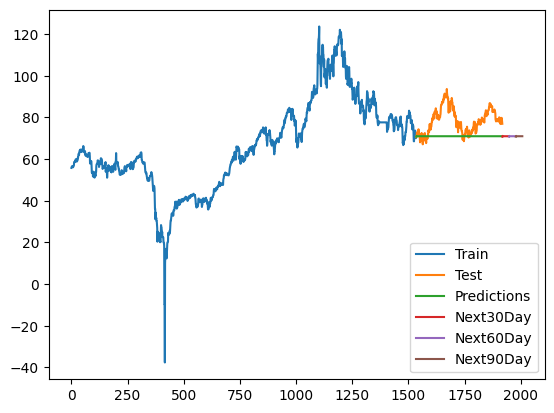

In [ ]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Gasoline RBOB - 8:2

In [ ]:
# Đọc file dữ liệu, loại bỏ những dòng bị thiếu và chuẩn hóa dữ liệu
df= pd.read_csv('Gasoline RBOB.csv')
df = df.dropna() # Drop missing values

In [ ]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Vol.' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

# Chuyển đổi cột 'Change %' thành số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
1626,2019-03-01,1.5356,1.7521,1.7720,1.7124,69010,-1.37
1624,2019-03-04,1.5530,1.7285,1.7660,1.7285,62550,-10.41
1623,2019-03-05,1.5601,1.7474,1.7735,1.7387,61430,0.46
1622,2019-03-06,1.5674,1.7604,1.7919,1.7524,91540,0.47
1621,2019-03-07,1.5743,1.7845,1.8160,1.7845,78590,0.44
...,...,...,...,...,...,...,...
4,2024-05-27,2.5140,2.5020,2.5154,2.5020,20,1.53
3,2024-05-28,2.5090,2.5151,2.5244,2.5022,330,-0.20
2,2024-05-29,2.4644,2.5208,2.5304,2.4579,1280,-1.78
1,2024-05-30,2.4046,2.4560,2.4613,2.4295,440,-2.43


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1335 entries, 1626 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1335 non-null   datetime64[ns]
 1   Price     1335 non-null   float64       
 2   Open      1335 non-null   float64       
 3   High      1335 non-null   float64       
 4   Low       1335 non-null   float64       
 5   Vol.      1335 non-null   int64         
 6   Change %  1335 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 83.4 KB


In [ ]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [ ]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [ ]:
# Tách dữ liệu train-test 8:2
train_size = int(0.8 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [ ]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape, '%')

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [ ]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5002.701, Time=2.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4938.852, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4962.590, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4962.766, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4940.630, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4990.964, Time=4.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4958.602, Time=1.64 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5038.333, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5036.269, Time=2.63 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-5036.316, Time=1.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-5036.716, Time=3.66 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5038.098, Time=5.76 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-5037.499, Time=1.48 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-5034.821, Time=4.98 sec
 ARIMA(3,1,2)(0,0,0

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing model
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [ ]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

# Dự đoán 60 ngày tiếp theo
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)

x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(n_periods=len(x_next_60_days))

print('Predict closing prices for the next 60 days:')
print(y_next_60_days)

#Dự đoán 90 ngày tiếp theo
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)

x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

print('Predict closing prices for the next 90 days:')
print(y_next_90_days)

Predict closing prices for the next 30 days:
[2.43409327 2.44366352 2.4475645  2.4460296  2.44243975 2.4401589
 2.44008789 2.44127878 2.44236378 2.44267181 2.44235044 2.44189928
 2.44167683 2.44172705 2.44189272 2.44201137 2.44202554 2.44197326
 2.44191944 2.44190053 2.44191324 2.44193476 2.4419468  2.44194567
 2.44193809 2.44193204 2.44193083 2.44193308 2.44193571 2.44193681]
Predict closing prices for the next 60 days:
[2.43409327 2.44366352 2.4475645  2.4460296  2.44243975 2.4401589
 2.44008789 2.44127878 2.44236378 2.44267181 2.44235044 2.44189928
 2.44167683 2.44172705 2.44189272 2.44201137 2.44202554 2.44197326
 2.44191944 2.44190053 2.44191324 2.44193476 2.4419468  2.44194567
 2.44193809 2.44193204 2.44193083 2.44193308 2.44193571 2.44193681]
Predict closing prices for the next 90 days:
[2.43409327 2.44366352 2.4475645  2.4460296  2.44243975 2.4401589
 2.44008789 2.44127878 2.44236378 2.44267181 2.44235044 2.44189928
 2.44167683 2.44172705 2.44189272 2.44201137 2.44202554 2.4419

- Calculate Error Values -
MAE:  0.21374373383141018
MAPE:  8.728631516111427 %
RMSE:  0.24263187326844357


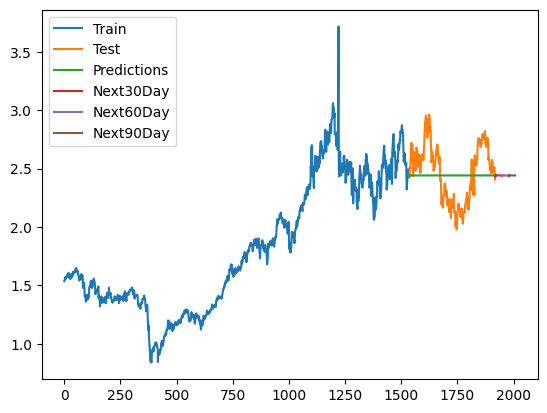

In [ ]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Heating Oil - 8:2

In [ ]:
# Đọc file dữ liệu, loại bỏ những dòng bị thiếu và chuẩn hóa dữ liệu
df= pd.read_csv('Heating Oil.csv')
df = df.dropna() # Drop missing values

In [ ]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Vol.' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

# Chuyển đổi cột 'Change %' thành số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
1384,2019-03-01,2.0010,2.0293,2.0479,1.9791,55010,-1.11
1383,2019-03-04,2.0143,1.9999,2.0377,1.9984,56050,0.66
1382,2019-03-05,2.0164,2.0110,2.0229,1.9909,45160,0.10
1381,2019-03-06,2.0162,2.0146,2.0256,1.9969,50220,-0.01
1380,2019-03-07,2.0127,2.0124,2.0356,1.9988,48590,-0.17
...,...,...,...,...,...,...,...
6,2024-05-24,2.4136,2.4175,2.4302,2.3897,21870,0.07
3,2024-05-28,2.4650,2.4148,2.4800,2.4131,28960,0.57
2,2024-05-29,2.4370,2.4801,2.4935,2.4295,22870,-1.14
1,2024-05-30,2.3694,2.4305,2.4368,2.3637,18120,-2.77


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1324 entries, 1384 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1324 non-null   datetime64[ns]
 1   Price     1324 non-null   float64       
 2   Open      1324 non-null   float64       
 3   High      1324 non-null   float64       
 4   Low       1324 non-null   float64       
 5   Vol.      1324 non-null   int64         
 6   Change %  1324 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 82.8 KB


In [ ]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [ ]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [ ]:
# Tách dữ liệu train-test 8:2
train_size = int(0.8 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [ ]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape, '%')

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [ ]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4010.551, Time=4.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3997.528, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4008.359, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4008.060, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3999.510, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4011.010, Time=2.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4006.315, Time=1.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4006.658, Time=0.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4004.086, Time=5.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-4006.498, Time=2.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4004.494, Time=0.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4017.532, Time=3.94 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-4019.334, Time=6.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4024.516, Time=3.58 sec
 ARIMA(3,1,1)(0,0,0

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing model
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [ ]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

# Dự đoán 60 ngày tiếp theo
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)

x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(n_periods=len(x_next_60_days))

print('Predict closing prices for the next 60 days:')
print(y_next_60_days)

#Dự đoán 90 ngày tiếp theo
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)

x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

print('Predict closing prices for the next 90 days:')
print(y_next_90_days)

Predict closing prices for the next 30 days:
[2.34565736 2.34360757 2.3470126  2.3472801  2.34433253 2.34618629
 2.3474162  2.3449739  2.34562734 2.34725893 2.3455616  2.34535161
 2.34694903 2.34601358 2.34530104 2.34659798 2.34630184 2.34539993
 2.34628256 2.34643746 2.34557488 2.34604452 2.34645405 2.34576677
 2.34589641 2.3463934  2.34593571 2.34583034 2.34629511 2.34606079]
Predict closing prices for the next 60 days:
[2.34565736 2.34360757 2.3470126  2.3472801  2.34433253 2.34618629
 2.3474162  2.3449739  2.34562734 2.34725893 2.3455616  2.34535161
 2.34694903 2.34601358 2.34530104 2.34659798 2.34630184 2.34539993
 2.34628256 2.34643746 2.34557488 2.34604452 2.34645405 2.34576677
 2.34589641 2.3463934  2.34593571 2.34583034 2.34629511 2.34606079]
Predict closing prices for the next 90 days:
[2.34565736 2.34360757 2.3470126  2.3472801  2.34433253 2.34618629
 2.3474162  2.3449739  2.34562734 2.34725893 2.3455616  2.34535161
 2.34694903 2.34601358 2.34530104 2.34659798 2.34630184 2.3

- Calculate Error Values -
MAE:  0.4044505547580468
MAPE:  13.867009674525585 %
RMSE:  0.4908052018036501


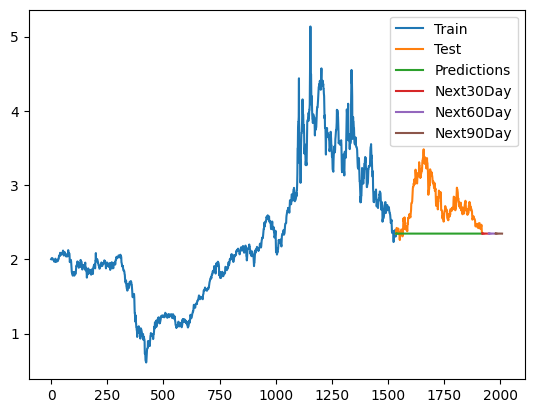

In [ ]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Train-Test 9:1

# Crude Oil WTI - 9:1

In [ ]:
# Đọc file dữ liệu và loại bỏ những dòng bị thiếu
df= pd.read_csv('Crude Oil WTI.csv')
df = df.dropna() # Drop missing values

In [ ]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Vol.' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

# Chuyển đổi cột 'Change %' thành số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
1385,2019-03-01,55.80,57.22,57.88,55.57,684190,-2.48
1384,2019-03-04,56.59,55.83,57.00,55.81,549400,1.42
1383,2019-03-05,56.56,56.45,57.19,56.09,538400,-0.05
1382,2019-03-06,56.22,56.28,56.40,55.42,637680,-0.60
1381,2019-03-07,56.66,56.20,56.99,56.08,628820,0.78
...,...,...,...,...,...,...,...
5,2024-05-24,77.72,77.04,78.05,76.15,299080,1.11
3,2024-05-28,79.83,77.81,80.29,77.69,334070,1.50
2,2024-05-29,79.23,80.26,80.62,78.99,259589,-0.75
1,2024-05-30,77.91,79.28,79.42,77.63,373780,-1.67


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1301 entries, 1385 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1301 non-null   datetime64[ns]
 1   Price     1301 non-null   float64       
 2   Open      1301 non-null   float64       
 3   High      1301 non-null   float64       
 4   Low       1301 non-null   float64       
 5   Vol.      1301 non-null   int64         
 6   Change %  1301 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 81.3 KB


In [ ]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [ ]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [ ]:
# Tách dữ liệu train-test 9:1
train_size = int(0.9 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [ ]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape, '%')

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [ ]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7392.696, Time=2.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7456.075, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7424.571, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7429.728, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7454.139, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7397.587, Time=1.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7399.238, Time=0.91 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7362.433, Time=1.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7361.323, Time=0.94 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7377.299, Time=0.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=7361.409, Time=1.53 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7408.833, Time=0.48 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=7360.113, Time=0.91 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=7361.322, Time=1.28 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept

ARIMA(order=(4, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing model
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [ ]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

# Dự đoán 60 ngày tiếp theo
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)

x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(n_periods=len(x_next_60_days))

print('Predict closing prices for the next 60 days:')
print(y_next_60_days)

#Dự đoán 90 ngày tiếp theo
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)

x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

print('Predict closing prices for the next 90 days:')
print(y_next_90_days)

Predict closing prices for the next 30 days:
[77.73817891 77.62950848 77.52487407 77.51483114 77.52605506 77.55084147
 77.56127231 77.56163206 77.55765279 77.55401557 77.55295301 77.55330884
 77.55412983 77.55460147 77.55467662 77.55455026 77.55441602 77.55436031
 77.55436593 77.5543935  77.55441303 77.55441814 77.55441458 77.55440967
 77.55440714 77.554407   77.55440789 77.55440866 77.55440894 77.55440885]
Predict closing prices for the next 60 days:
[77.73817891 77.62950848 77.52487407 77.51483114 77.52605506 77.55084147
 77.56127231 77.56163206 77.55765279 77.55401557 77.55295301 77.55330884
 77.55412983 77.55460147 77.55467662 77.55455026 77.55441602 77.55436031
 77.55436593 77.5543935  77.55441303 77.55441814 77.55441458 77.55440967
 77.55440714 77.554407   77.55440789 77.55440866 77.55440894 77.55440885]
Predict closing prices for the next 90 days:
[77.73817891 77.62950848 77.52487407 77.51483114 77.52605506 77.55084147
 77.56127231 77.56163206 77.55765279 77.55401557 77.55295301

- Calculate Error Values -
MAE:  3.5659887709377145
MAPE:  4.601393097103382 %
RMSE:  4.378421049879778


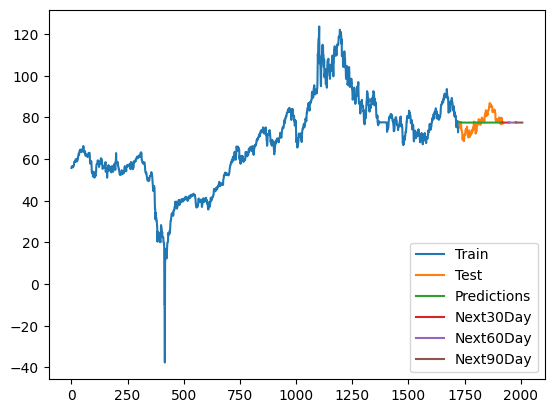

In [ ]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Gasoline RBOB - 9:1

In [ ]:
# Đọc file dữ liệu, loại bỏ những dòng bị thiếu và chuẩn hóa dữ liệu
df= pd.read_csv('Gasoline RBOB.csv')
df = df.dropna() # Drop missing values

In [ ]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Vol.' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

# Chuyển đổi cột 'Change %' thành số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
1626,2019-03-01,1.5356,1.7521,1.7720,1.7124,69010,-1.37
1624,2019-03-04,1.5530,1.7285,1.7660,1.7285,62550,-10.41
1623,2019-03-05,1.5601,1.7474,1.7735,1.7387,61430,0.46
1622,2019-03-06,1.5674,1.7604,1.7919,1.7524,91540,0.47
1621,2019-03-07,1.5743,1.7845,1.8160,1.7845,78590,0.44
...,...,...,...,...,...,...,...
4,2024-05-27,2.5140,2.5020,2.5154,2.5020,20,1.53
3,2024-05-28,2.5090,2.5151,2.5244,2.5022,330,-0.20
2,2024-05-29,2.4644,2.5208,2.5304,2.4579,1280,-1.78
1,2024-05-30,2.4046,2.4560,2.4613,2.4295,440,-2.43


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1335 entries, 1626 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1335 non-null   datetime64[ns]
 1   Price     1335 non-null   float64       
 2   Open      1335 non-null   float64       
 3   High      1335 non-null   float64       
 4   Low       1335 non-null   float64       
 5   Vol.      1335 non-null   int64         
 6   Change %  1335 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 83.4 KB


In [ ]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [ ]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [ ]:
# Tách dữ liệu train-test 9:1
train_size = int(0.9 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [ ]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape, '%')

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [ ]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5642.629, Time=2.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5587.567, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5606.639, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5605.981, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5589.444, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5627.440, Time=5.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5615.731, Time=2.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5674.549, Time=0.64 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5673.149, Time=3.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-5672.347, Time=2.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-5672.941, Time=7.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5674.693, Time=3.96 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5671.721, Time=1.88 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-5672.778, Time=7.12 sec
 ARIMA(1,1,4)(0,0,0

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing model
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [ ]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

# Dự đoán 60 ngày tiếp theo
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)

x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(n_periods=len(x_next_60_days))

print('Predict closing prices for the next 60 days:')
print(y_next_60_days)

#Dự đoán 90 ngày tiếp theo
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)

x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

print('Predict closing prices for the next 90 days:')
print(y_next_90_days)

Predict closing prices for the next 30 days:
[2.23082726 2.22917863 2.2226001  2.22072229 2.22193098 2.22289891
 2.22289923 2.22262286 2.2225241  2.22256778 2.22261159 2.22261475
 2.22260337 2.2225984  2.22259988 2.22260182 2.2226021  2.22260164
 2.2226014  2.22260144 2.22260153 2.22260154 2.22260153 2.22260151
 2.22260151 2.22260152 2.22260152 2.22260152 2.22260152 2.22260152]
Predict closing prices for the next 60 days:
[2.23082726 2.22917863 2.2226001  2.22072229 2.22193098 2.22289891
 2.22289923 2.22262286 2.2225241  2.22256778 2.22261159 2.22261475
 2.22260337 2.2225984  2.22259988 2.22260182 2.2226021  2.22260164
 2.2226014  2.22260144 2.22260153 2.22260154 2.22260153 2.22260151
 2.22260151 2.22260152 2.22260152 2.22260152 2.22260152 2.22260152]
Predict closing prices for the next 90 days:
[2.23082726 2.22917863 2.2226001  2.22072229 2.22193098 2.22289891
 2.22289923 2.22262286 2.2225241  2.22256778 2.22261159 2.22261475
 2.22260337 2.2225984  2.22259988 2.22260182 2.2226021  2.2

- Calculate Error Values -
MAE:  0.2584038930533559
MAPE:  10.086886124396468 %
RMSE:  0.3180759687089079


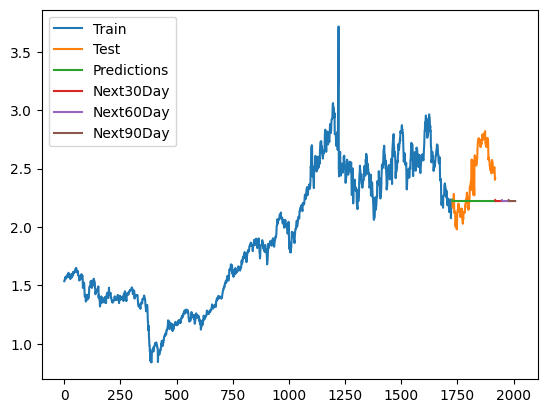

In [ ]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Heating Oil - 9:1

In [ ]:
# Đọc file dữ liệu, loại bỏ những dòng bị thiếu và chuẩn hóa dữ liệu
df= pd.read_csv('Heating Oil.csv')
df = df.dropna() # Drop missing values

In [ ]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Vol.' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

# Chuyển đổi cột 'Change %' thành số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
1384,2019-03-01,2.0010,2.0293,2.0479,1.9791,55010,-1.11
1383,2019-03-04,2.0143,1.9999,2.0377,1.9984,56050,0.66
1382,2019-03-05,2.0164,2.0110,2.0229,1.9909,45160,0.10
1381,2019-03-06,2.0162,2.0146,2.0256,1.9969,50220,-0.01
1380,2019-03-07,2.0127,2.0124,2.0356,1.9988,48590,-0.17
...,...,...,...,...,...,...,...
6,2024-05-24,2.4136,2.4175,2.4302,2.3897,21870,0.07
3,2024-05-28,2.4650,2.4148,2.4800,2.4131,28960,0.57
2,2024-05-29,2.4370,2.4801,2.4935,2.4295,22870,-1.14
1,2024-05-30,2.3694,2.4305,2.4368,2.3637,18120,-2.77


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1324 entries, 1384 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1324 non-null   datetime64[ns]
 1   Price     1324 non-null   float64       
 2   Open      1324 non-null   float64       
 3   High      1324 non-null   float64       
 4   Low       1324 non-null   float64       
 5   Vol.      1324 non-null   int64         
 6   Change %  1324 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 82.8 KB


In [ ]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [ ]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [ ]:
# Tách dữ liệu train-test 9:1
train_size = int(0.9 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [ ]:
# Tạo hàm đánh giá sai số cho dự đoán (sử dụng MAE, MAPE, RMSE)
def evaluate(test,pred):
  print('- Calculate Error Values -')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape, '%')

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

In [ ]:
# Training model
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Tìm mô hình ARIMA tối ưu nhất
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4591.622, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4579.852, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4590.878, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4590.484, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4581.732, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4587.175, Time=1.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4607.511, Time=5.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4586.333, Time=0.89 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-4590.493, Time=4.82 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-4596.619, Time=6.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4610.084, Time=4.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4587.266, Time=2.04 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-4595.281, Time=7.68 sec
 ARIMA(1,1,4)(0,0,0)[0] i

ARIMA(order=(3, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing model
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [ ]:
# Dự đoán 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

print('Predict closing prices for the next 30 days:')
print(y_next_30_days)

# Dự đoán 60 ngày tiếp theo
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)

x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(n_periods=len(x_next_60_days))

print('Predict closing prices for the next 60 days:')
print(y_next_60_days)

#Dự đoán 90 ngày tiếp theo
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)

x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

print('Predict closing prices for the next 90 days:')
print(y_next_90_days)

Predict closing prices for the next 30 days:
[2.92558912 2.93120917 2.93523303 2.92452539 2.92462604 2.92096084
 2.9175959  2.91696585 2.91388422 2.91316564 2.9115876  2.91042487
 2.9097201  2.90868838 2.90818321 2.90753064 2.90705136 2.90666823
 2.9062743  2.90600849 2.90573475 2.90552358 2.90534277 2.90517942
 2.9050527  2.90493533 2.9048408  2.90475907 2.90468849 2.90463048]
Predict closing prices for the next 60 days:
[2.92558912 2.93120917 2.93523303 2.92452539 2.92462604 2.92096084
 2.9175959  2.91696585 2.91388422 2.91316564 2.9115876  2.91042487
 2.9097201  2.90868838 2.90818321 2.90753064 2.90705136 2.90666823
 2.9062743  2.90600849 2.90573475 2.90552358 2.90534277 2.90517942
 2.9050527  2.90493533 2.9048408  2.90475907 2.90468849 2.90463048]
Predict closing prices for the next 90 days:
[2.92558912 2.93120917 2.93523303 2.92452539 2.92462604 2.92096084
 2.9175959  2.91696585 2.91388422 2.91316564 2.9115876  2.91042487
 2.9097201  2.90868838 2.90818321 2.90753064 2.90705136 2.9

- Calculate Error Values -
MAE:  0.2611487807686535
MAPE:  10.117020627156286 %
RMSE:  0.28856598581221


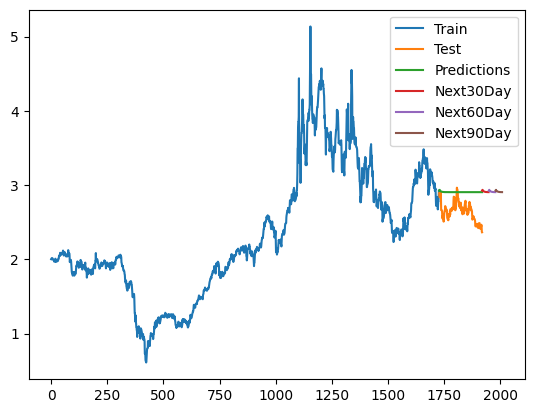

In [ ]:
# Đánh giá mô hình dựa trên các đánh giá sai số và vẽ đồ thị đường
evaluate(y_test, y_pred)

plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()